## Logistic Regression

Logistic regression is the process of estimating the **relationship** between **probability of a discreet event** and the independent variables or the regressors.

**Non-linear** decision boundary can be captured by linear logistic model by adding nonlinear features. This is because the model is linear with respect to the parameters. 

**Non-linear (Polynomial)** decision boundary can be captured by linear logistic model by adding nonlinear features. This is because the model is linear with respect to the parameters. 

**Regularization** is a method of controlling model complexity without removing features.

**Multi-Class Logistic Regression** requires Multiple Binary Logistic Regression Analysis to differentiate classes from each other.

----
### Logistic Model (Linear decision boundary)

$$p_i=logistic\left(\sum_jx_{ij}\theta_j\right)$$
Where,
$$ logistic(z)=\frac{1}{1+e^{-z}} $$

|Symbol | Description |
| :---: | :--- |
| $p_i$ | Probability of an event occuring |
| $x_{ij}$ | Design matrix containing regressors of the training data |
| $\theta_j$ | Coefficients of the inner linear model |


In [1]:
clc
close all
clear all
format long
ver Octave

----------------------------------------------------------------------
GNU Octave Version: 7.1.0 (hg id: 04120d65778a)
GNU Octave License: GNU General Public License
Operating System: MINGW32_NT-6.2 Windows 6.2  x86_64
----------------------------------------------------------------------


### Hypothesis function (Binary Logistic Regression)

$$ f_\theta([X]_i)=logistic\left(\sum_jx_{ij}\theta_j\right)=\frac{1}{1+e^{-\left(\sum_jx_{ij}\theta_j\right)}} $$

In [2]:
function f=hypothesisFunction(X,theta)
    f=1./(1+exp(-X*theta));
endfunction

### Prediction function (Binary Logistic Regression)
Taking 0.5 as the threshold probability.

$$ g_\theta([X])=\begin{cases}
 & 1, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) \geq 0.5\\
 & 0, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) <  0.5
\end{cases}$$

In [3]:
function y=predictionFunction(X,theta,threshold=0.5)
    y=(hypothesisFunction(X,theta)>=threshold);
endfunction

### Cost Function and its gradient (Regularized)

$$\begin{aligned}
J([X],y,\theta) & = \frac{1}{m}\sum_{i=1}^m{cost(f_\theta([x]_i),y_i)}+\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
& = -\frac{1}{m}\sum_{i=1}^m{\left[y_ilog(f_\theta([x]_i))+(1-y_i)log(1-f_\theta([x]_i)) \right]} +\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
\nabla J([X],y,\theta)_{j=1} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}}  \\
\nabla J([X],y,\theta)_{j=2..n} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}} + \frac{\lambda}{m}\theta_j
\end{aligned}
$$
Where,
$$ cost(f_\theta([x]_i),y_i) = \begin{cases}
 & -log(f_\theta([x]_i)), &\text{ if } y_i = 1\\
 & -log(1-f_\theta([x]_i)), &\text{ if } y_i = 0
\end{cases}$$

In [4]:
function [J,gradJ]=costFunctionWithGrad(X,y,theta,lambda=0.1)
    h=hypothesisFunction(X,theta);
    m=length(y);
    J = 1/m*sum(-y.*log(h)-(1-y).*log(1-h))+lambda/2/m*sum(theta(2:end).^2);
    gradJ = 1/m*sum((h-y).*X)'+lambda/m*(theta-[theta(1);zeros(length(theta)-1,1)]);
endfunction

### Model parameter estimation
Minimizing cost by utilizing gradient information

In [5]:
function [f,theta,cost]=modelFit(X,y,initial_theta,lambda=0.1,max_iterations=400)
    options = optimset('GradObj', 'on', 'MaxIter', max_iterations, 'AutoScaling','on');
    [theta, cost] = fminunc(@(t)(costFunctionWithGrad(X, y, t,lambda)), initial_theta, options);
    f=@(X) predictionFunction(X,theta);
endfunction

### Confusion Matrix
$$ \text{True Positive (TP) = Num. of True predictions where target is True} $$
$$ \text{True Negative (TN) = Num. of False predictions where target is False} $$
$$ \text{False Positive (FP) = Num. of True predictions where target is False} $$
$$ \text{False Negative (FN) = Num. of False predictions where target is True} $$

|  |(+) Prediction | (-) Prediction |
|:---:|:---:|:---:|
|(+) Actual | TP | FN |
|(-) Actual | FP | TN |



In [6]:
function C=ConfusionMatrix(p,t)
    TruePositive=sum(p==t & t==1);
    TrueNeagtive=sum(p==t & t==0);
    FalsePositive=sum(p~=t & t==0);
    FalseNegative=sum(p~=t & t==1);
    C=[TruePositive  , FalseNegative; 
       FalsePositive , TrueNeagtive];
endfunction

function printCell(c)
    printf ([sprintf("%%%is", max (cellfun (@numel, c))+8) "\n"], c'{:})
endfunction

function prettyprintConfusionMatrix(C)
    Z=cell(3);
    Z(1,1)="|";
    Z(1,2)="Pred. (+) |";
    Z(1,3)="Pred. (-) |";
    Z(2,1)="Actual (+) |";
    Z(3,1)="Actual (-) |";
    Z(2,2)=num2str(C(1,1),"%-8d |");
    Z(2,3)=num2str(C(1,2),"%-8d |");
    Z(3,2)=num2str(C(2,1),"%-8d |");
    Z(3,3)=num2str(C(2,2),"%-8d |");
    printCell(Z);
endfunction

### MNIST Database Reader
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

In [7]:
function [imageData,imageSize]=read_MNIST_Images(fileLoc)
    if endsWith(fileLoc,".idx3-ubyte")==1
        [~,fn,fe]=fileparts(fileLoc);
        printf("Reading: %s\n",[fn,fe]);
        inFile=fopen(fileLoc,"r");
        header=fread(inFile,4,"uint32",0,"ieee-be");
        [data,count]=fread(inFile,header(2)*header(3)*header(4),...
                            "uint8",0,"ieee-be");
        fclose(inFile);
        if count~=header(2)*header(3)*header(4)
            disp("Error reading data")
        endif
        imageData=reshape(data,header(3)*header(4),[])';
        imageSize=[header(3) header(4)];
    else
        disp("Can only read *.idx3-ubyte files");
    endif
endfunction

function targetLabelsData=read_MNIST_Labels(fileLoc)
    if endsWith(fileLoc,".idx1-ubyte")==1
        [~,fn,fe]=fileparts(fileLoc);
        printf("Reading: %s\n",[fn,fe]);
        inFile=fopen(fileLoc,"r");
        header=fread(inFile,2,"uint32",0,"ieee-be");
        [data,count]=fread(inFile,header(2),...
                            "uint8",0,"ieee-be");
        fclose(inFile);
        if count~=header(2)
            disp("Error reading data")
        endif
        targetLabelsData=data;
    else
        disp("Can only read *.idx1-ubyte files");
    endif
endfunction

### Data Visualization

In [8]:
function showImagesLabels(indices,imageData,labelsData,imageSize)
    n=numel(indices);
    nc=ceil(sqrt(n));
    nr=ceil(n/nc);

    img=ones(imageSize.*[nr,nc])*255;
    for k=1:n
        c=mod((k-1),nc)*imageSize(2)+1;
        r=floor((k-1)/nc)*imageSize(1)+1;
        img(r:r+imageSize(1)-1,c:c+imageSize(2)-1)=255-reshape(imageData(indices(k),:),imageSize')';
    endfor
    colormap("gray");
    imagesc(img);
    xticks([])
    yticks([])
    title("Image preview");
    disp("Target Labels:");
    disp(reshape(labelsData(indices),[nr,nc]')');
endfunction

### Main Program

Reads MNIST database and performs multi-class logistic regression analysis.

Reading MNIST Training Database
Reading: train-images.idx3-ubyte
Reading: train-labels.idx1-ubyte
First 100 Entries:
Target Labels:
   5   0   4   1   9   2   1   3   1   4
   3   5   3   6   1   7   2   8   6   9
   4   0   9   1   1   2   4   3   2   7
   3   8   6   9   0   5   6   0   7   6
   1   8   7   9   3   9   8   5   9   3
   3   0   7   4   9   8   0   9   4   1
   4   4   6   0   4   5   6   1   0   0
   1   7   1   6   3   0   2   1   1   7
   9   0   2   6   7   8   3   9   0   4
   6   7   4   6   8   0   7   8   3   1


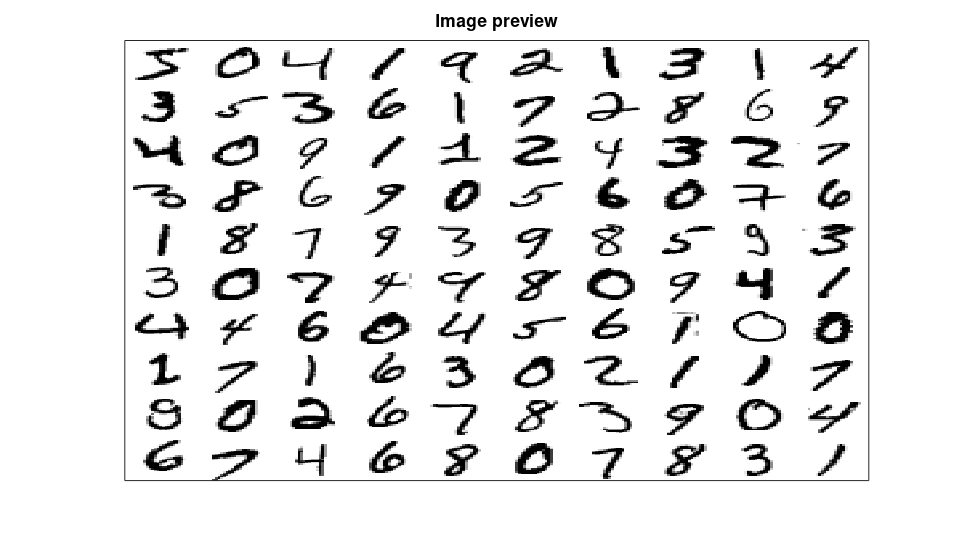

In [9]:
format short
disp("Reading MNIST Training Database");
[fname,fpath]=uigetfile("*.idx3-ubyte","Image Database");
fileLocImages=fullfile(fpath,fname);
[imageData imageSize]=read_MNIST_Images(fileLocImages);

[fname,fpath]=uigetfile("*.idx1-ubyte","Label Database");
fileLocLabels=fullfile(fpath,fname);
labelsData=read_MNIST_Labels(fileLocLabels);

disp("First 100 Entries:");
showImagesLabels(1:100,imageData,labelsData,imageSize);

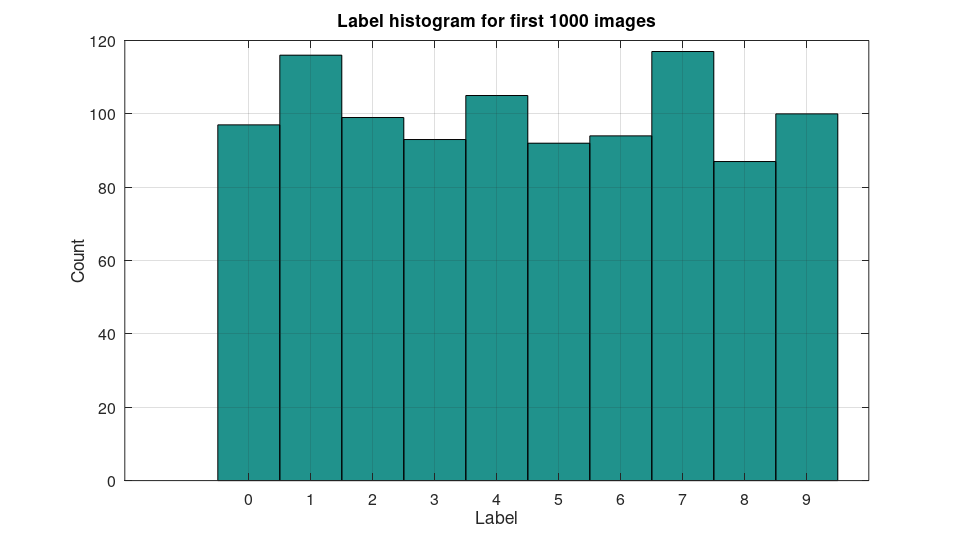

In [10]:
hist(labelsData(1:1000),(0:9))
xticks(0:9)
grid("on")
title("Label histogram for first 1000 images");
xlabel("Label");
ylabel("Count");

### Training Phase

In [11]:
X=[ones(1000,1) imageData(1:1000,:)];
y=labelsData(1:1000);
T=zeros(size(X,2),10);
count=0;
disp("----------------------------")
for k=1:10
    initial_theta=zeros(size(X,2),1);
    [fitM,theta,cost]=modelFit(X,y==(k-1),initial_theta,lambda=10,max_iterations=1000);
    T(:,k)=theta;
    C=ConfusionMatrix(fitM(X),y==(k-1));
    printf('Confusion Matrix for digit: %d\n',k-1);
    prettyprintConfusionMatrix(C);
    printf("Cost = %g\n",cost)
    count=count+C(1);
    disp("----------------------------")
endfor
printf("Training Accuracy = %g%%\n",count/1000*100)

----------------------------
Confusion Matrix for digit: 0
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         97       |         0        |
        Actual (-) |         0        |         903      |
Cost = 2.79348e-05
----------------------------
Confusion Matrix for digit: 1
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         116      |         0        |
        Actual (-) |         0        |         884      |
Cost = 5.82706e-05
----------------------------
Confusion Matrix for digit: 2
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         99       |         0        |
        Actual (-) |         0        |         901      |
Cost = 0.000155316
----------------------------
Confusion Matrix for digit: 3
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         93       |         0        |
        Actual (-) |         0        |         907      |

Reading MNIST Testing Database
Reading: t10k-images.idx3-ubyte
Reading: t10k-labels.idx1-ubyte
First 100 Entries:
Target Labels:
   7   2   1   0   4   1   4   9   5   9
   0   6   9   0   1   5   9   7   3   4
   9   6   6   5   4   0   7   4   0   1
   3   1   3   4   7   2   7   1   2   1
   1   7   4   2   3   5   1   2   4   4
   6   3   5   5   6   0   4   1   9   5
   7   8   9   3   7   4   6   4   3   0
   7   0   2   9   1   7   3   2   9   7
   7   6   2   7   8   4   7   3   6   1
   3   6   9   3   1   4   1   7   6   9


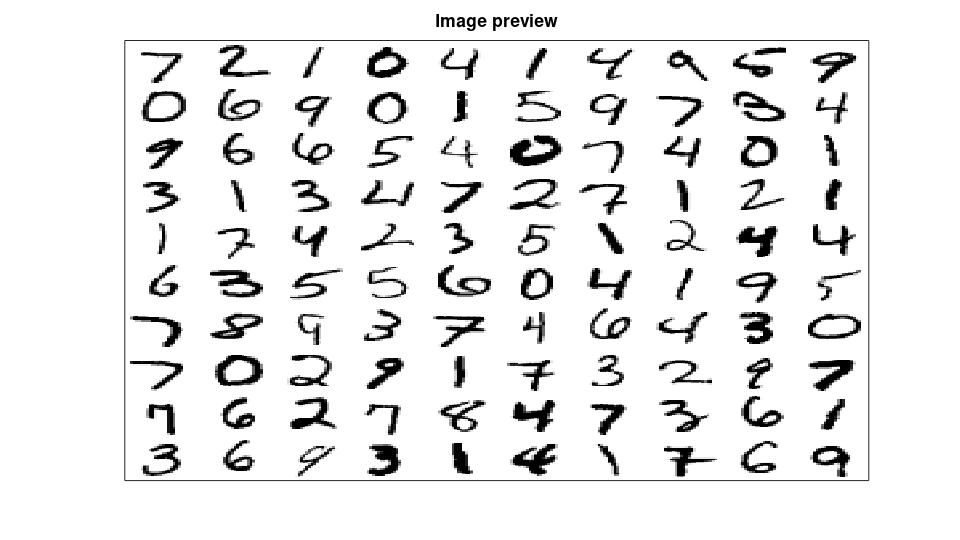

In [12]:
disp("Reading MNIST Testing Database");
[fname,fpath]=uigetfile("*.idx3-ubyte","Image Database");
fileLocImages=fullfile(fpath,fname);
[imageDataTest imageSizeTest]=read_MNIST_Images(fileLocImages);

[fname,fpath]=uigetfile("*.idx1-ubyte","Label Database");
fileLocLabels=fullfile(fpath,fname);
labelsDataTest=read_MNIST_Labels(fileLocLabels);

disp("First 100 Entries:");
showImagesLabels(1:100,imageDataTest,labelsDataTest,imageSizeTest);

### Testing Phase

In [13]:
X=[ones(1000,1) imageDataTest(1:1000,:)];
y=labelsDataTest(1:1000);
p=predictionFunction(X,T);
disp("----------------------------")
count=0;
for k=1:10
    C=ConfusionMatrix(p(:,k),y==(k-1));
    printf('Confusion Matrix for digit: %d\n',k-1);
    prettyprintConfusionMatrix(C);
    count=count+C(1);
    disp("----------------------------")
endfor
printf("Testing Accuracy = %g%%\n",count/1000*100)

----------------------------
Confusion Matrix for digit: 0
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         79       |         6        |
        Actual (-) |         7        |         908      |
----------------------------
Confusion Matrix for digit: 1
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         122      |         4        |
        Actual (-) |         8        |         866      |
----------------------------
Confusion Matrix for digit: 2
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         89       |         27       |
        Actual (-) |         13       |         871      |
----------------------------
Confusion Matrix for digit: 3
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         80       |         27       |
        Actual (-) |         20       |         873      |
----------------------------
Confusion Matrix for digit:

Predicted labels for first 100 Test Images:
   7   2   1   0   4   1   4   9   0   0
   0   0   9   0   1   5   7   7   3   4
   9   6   4   5   4   0   7   4   0   1
   3   1   3   4   7   2   7   1   3   1
   1   7   4   2   0   5   1   2   4   4
   6   3   4   5   0   0   4   1   9   5
   3   0   9   2   0   3   0   4   3   0
   7   0   2   7   1   7   3   2   9   7
   0   6   2   7   8   4   7   0   6   1
   3   6   9   0   1   4   1   0   6   7
Target Labels:
   7   2   1   0   4   1   4   9   5   9
   0   6   9   0   1   5   9   7   3   4
   9   6   6   5   4   0   7   4   0   1
   3   1   3   4   7   2   7   1   2   1
   1   7   4   2   3   5   1   2   4   4
   6   3   5   5   6   0   4   1   9   5
   7   8   9   3   7   4   6   4   3   0
   7   0   2   9   1   7   3   2   9   7
   7   6   2   7   8   4   7   3   6   1
   3   6   9   3   1   4   1   7   6   9


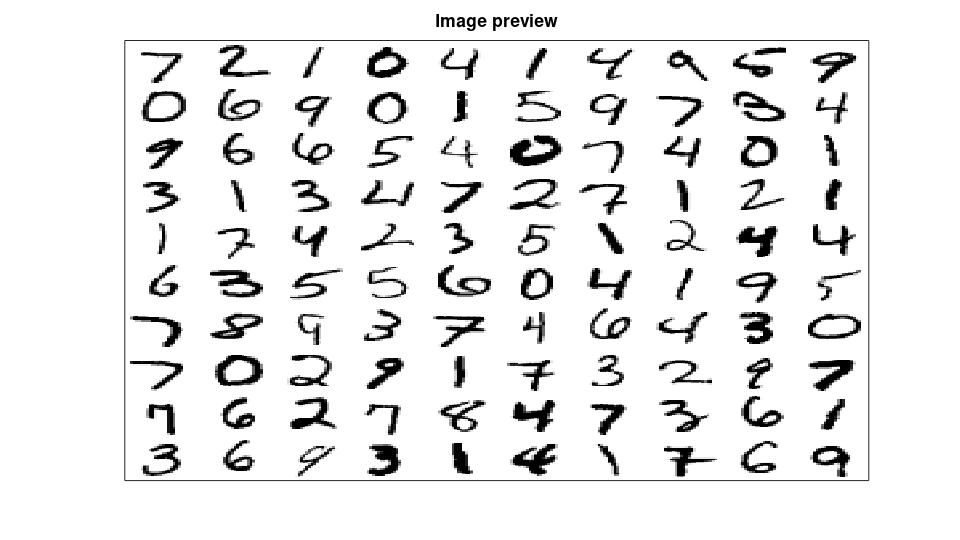

In [14]:
[~,q]=max(p(1:100,:),[],2);
disp("Predicted labels for first 100 Test Images:");
disp(reshape(q-1,10,[])');
showImagesLabels(1:100,imageDataTest,labelsDataTest,imageSizeTest);